In [1]:
import torch

In [2]:
import sys
from pathlib import Path


PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

In [3]:
from src.gpt_download import download_and_load_gpt2
from src.utility import load_weights_into_gpt
from decoder_only_transformer.src.gpt_arch import GPTModel, generate_text_simple, generate
from decoder_only_transformer.src.tokenization_embeddings import text_to_token_ids, token_ids_to_text, create_dataloader_v1
from decoder_only_transformer.src.pretrain_model import train_model_simple, calc_loss_loader
from decoder_only_transformer.src.utility import plot_losses
from src.fine_tune_instruct import InstructionDataset, custom_collate_fn, format_input

2025-12-26 14:17:53.428514: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-26 14:17:53.732071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-26 14:17:54.892123: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/erna/venv/dev_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: Fut

In [4]:
import json 
with open("data/instruction-data.json", "r") as f:
    data = json.load(f)

In [5]:
print("Number of entries:", len(data))

Number of entries: 1100


In [6]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [7]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [8]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [11]:
from functools import partial
customized_collate_fn = partial(
custom_collate_fn,
device=device,
allowed_max_length=1024
)

In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
train_dataset,
batch_size=batch_size,
collate_fn=customized_collate_fn,
shuffle=True,
drop_last=True,
num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
val_dataset,
batch_size=batch_size,
collate_fn=customized_collate_fn,
shuffle=False,
drop_last=False,
num_workers=num_workers
)
test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
test_dataset,
batch_size=batch_size,
collate_fn=customized_collate_fn,
shuffle=False,
drop_last=False,
num_workers=num_workers
)

In [13]:
BASE_CONFIG = {
"vocab_size": 50257,
"context_length": 1024,
"drop_rate": 0.0,
"qkv_bias": True
}

In [14]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [15]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [16]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size,
models_dir="model/gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: model/gpt2/124M/checkpoint
File already exists and is up-to-date: model/gpt2/124M/encoder.json
File already exists and is up-to-date: model/gpt2/124M/hparams.json
File already exists and is up-to-date: model/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: model/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: model/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: model/gpt2/124M/vocab.bpe


In [17]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [18]:
token_ids = generate(
model=model,
idx=text_to_token_ids(input_text, tokenizer),
max_new_tokens=35,
context_size=BASE_CONFIG["context_length"],
eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [19]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


In [20]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=5
    )
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.167139053344727
Validation loss: 4.0509350299835205


In [21]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=5,
start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.119, Val loss 3.069
Ep 1 (Step 000005): Train loss 1.696, Val loss 1.570
Ep 1 (Step 000010): Train loss 1.096, Val loss 1.164
Ep 1 (Step 000015): Train loss 1.053, Val loss 1.083
Ep 1 (Step 000020): Train loss 0.970, Val loss 1.038
Ep 1 (Step 000025): Train loss 0.920, Val loss 1.002
Ep 1 (Step 000030): Train loss 0.960, Val loss 0.978
Ep 1 (Step 000035): Train loss 0.877, Val loss 0.951
Ep 1 (Step 000040): Train loss 0.847, Val loss 0.943
Ep 1 (Step 000045): Train loss 0.777, Val loss 0.925
Ep 1 (Step 000050): Train loss 0.869, Val loss 0.911
Ep 1 (Step 000055): Train loss 0.924, Val loss 0.893
Ep 1 (Step 000060): Train loss 0.873, Val loss 0.877
Ep 1 (Step 000065): Train loss 0.800, Val loss 0.867
Ep 1 (Step 000070): Train loss 0.694, Val loss 0.860
Ep 1 (Step 000075): Train loss 0.706, Val loss 0.856
Ep 1 (Step 000080): Train loss 0.753, Val loss 0.847
Ep 1 (Step 000085): Train loss 0.680, Val loss 0.836
Ep 1 (Step 000090): Train loss 0.729, Val loss

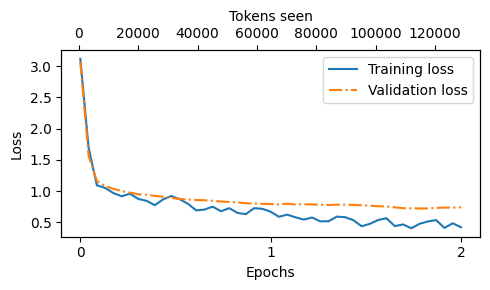

In [22]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [23]:
torch.manual_seed(123)
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=256,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a tropical rainforest.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 

In [24]:
from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=256,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
    )
    test_data[i]["model_response"] = response_text


  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [00:13<00:00,  8.43it/s]


In [25]:
with open("data/instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

In [26]:
import re
file_name = f"model/{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as model/gpt2-small124M-sft.pth
